# AlexNet and ResNet-56 on CIFAR10 (Knowledge Distillation)

### Imports and Setup

In [1]:
# PyTorch and Models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from architectures.AlexNet import AlexNet
from architectures.ResNet56 import resnet56
import numpy as np

# Helper functions
import datasets.datasets as datasets
from util.common import *
from util.trainer import distillation_training

import matplotlib.pyplot as plt

In [2]:
# Make PyTorch deterministic
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Data, Training and Test Sets

In [3]:
#Loading dataset into training and test data
training_loader = datasets.cifar10_training_loader()
test_loader = datasets.cifar10_test_loader()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Define different temperatures and label smoothing factors
smoothing_factors_student = [0, 0.15, 0.3, 0.45, 0.6, 0.75]
smoothing_factors_teacher = [0, 0.15, 0.3, 0.45, 0.6, 0.75]
temperatures_teacher = [1.0, 2.0, 4.0, 8.0, 12.0, 16.0]

### Distillation training loop

In [6]:
def train_distillation(alexnet, resnet, device, training_loader, temperature, epochs):
    cross_entropy = nn.CrossEntropyLoss()
    train_loss = lambda outputs, labels, pred: 3*cross_entropy(outputs, pred) + 4e-2 * (torch.norm(list(alexnet.classifier.parameters())[2]) + torch.norm(list(alexnet.classifier.parameters())[0]))
    
    opt = optim.SGD(params= alexnet.parameters(), lr=0.1)

    scheduler = MultiStepLR(opt, [415, 830], 0.1)
    
    distillation_training(resnet, alexnet, device, training_loader, test_loader, epochs, train_loss, opt, scheduler, temperature)

### Training Student with Label Smoothing without Distillation

In [ ]:
for j, elem in enumerate(smoothing_factors_student):
    model = AlexNet(num_classes=10)
    model.train_model(device, training_loader, test_loader, elem, NUM_EPOCHS_ALEXNET)
    torch.save(model.state_dict(), f"models/ResNet56_AlexNet_CIFAR10_Distillation/AlexNet_Student_Smoothing_{j}.pt")

### Training Teacher with Label Smoothing

In [ ]:
model = resnet56(num_classes=10)
model.train_model(device, training_loader, test_loader, smoothing_factors_teacher[0], NUM_EPOCHS_RESNET_56)
torch.save(model.state_dict(), f"models/ResNet56_AlexNet_CIFAR10_Distillation/ResNet_Teacher_Smoothing_0.pt")
torch.save(model.state_dict(), "models/ResNet56_CIFAR10_Accuracy_IMC/ResNet_Hard_Labels_CIFAR10.pt")


model = resnet56(num_classes=10)
model.train_model(device, training_loader, test_loader, smoothing_factors_teacher[1], NUM_EPOCHS_RESNET_56)
torch.save(model.state_dict(), f"models/ResNet56_AlexNet_CIFAR10_Distillation/ResNet_Teacher_Smoothing_1.pt")
torch.save(model.state_dict(), "models/ResNet56_CIFAR10_Accuracy_IMC/ResNet_Smooth_Labels_015_CIFAR10.pt")

model = resnet56(num_classes=10)
model.train_model(device, training_loader, test_loader, smoothing_factors_teacher[2], NUM_EPOCHS_RESNET_56)
torch.save(model.state_dict(), f"models/ResNet56_AlexNet_CIFAR10_Distillation/ResNet_Teacher_Smoothing_2.pt")
torch.save(model.state_dict(), "models/ResNet56_CIFAR10_Accuracy_IMC/ResNet_Smooth_Labels_03_CIFAR10.pt")

for j, elem in enumerate(smoothing_factors_teacher[3:]):
    model = resnet56(num_classes=10)
    model.train_model(device, training_loader, test_loader, elem, NUM_EPOCHS_RESNET_56)
    torch.save(model.state_dict(), f"models/ResNet56_AlexNet_CIFAR10_Distillation/ResNet_Teacher_Smoothing_{j}.pt")

### Training Student with Distillation (Temperature-scaled Teacher)

In [ ]:
for j, elem in enumerate(temperatures_teacher):
    model = resnet56(num_classes=10)
    model.load_state_dict(torch.load(f"models/ResNet56_AlexNet_CIFAR10_Distillation/ResNet_Teacher_Smoothing_0.pt",map_location=device))
    model2 = AlexNet(num_classes=10)
    
    train_distillation(model2, model, device, training_loader, elem, NUM_EPOCHS_ALEXNET)
    torch.save(model2.state_dict(), f"models/ResNet56_AlexNet_CIFAR10_Distillation/AlexNet_Distillation_Temperature_{j}.pt")

### Training Student with Distillation (Label-smoothed Teacher)

In [ ]:
for j, elem in enumerate(smoothing_factors_teacher):
    model = resnet56(num_classes=10)
    model.load_state_dict(torch.load(f"models/ResNet56_AlexNet_CIFAR10_Distillation/ResNet_Teacher_Smoothing_{j}.pt",map_location=device))
    model2 = AlexNet(num_classes=10)
    
    train_distillation(model2, model, device, training_loader, 1, NUM_EPOCHS_ALEXNET)
    torch.save(model2.state_dict(), f"models/ResNet56_AlexNet_CIFAR10_Distillation/AlexNet_Distillation_Smoothing_{j}.pt")

## Visualize the results in plot

In [14]:
student = []
for j, elem in enumerate(smoothing_factors_student):
    model = AlexNet(num_classes=10)
    model.load_state_dict(torch.load(f"models/ResNet56_AlexNet_CIFAR10_Distillation/AlexNet_Student_Smoothing_{j}.pt", 
                                     map_location=device, weights_only=True))
    model.to(device)
    student.append([elem, *compute_accuracy(model, test_loader, device, return_err=True)])

In [6]:
teacher = []
for j, elem in enumerate(smoothing_factors_teacher):
    model = resnet56(num_classes=10)
    model.load_state_dict(torch.load(f"models/ResNet56_AlexNet_CIFAR10_Distillation/ResNet_Teacher_Smoothing_{j}.pt", 
                                     map_location=device, weights_only=True))
    model.to(device)
    teacher.append([elem, *compute_accuracy(model, test_loader, device, return_err=True)])

/var/folders/sk/xqbjcxln3zzg7nr8z_6mxr3h0000gq/T/ipykernel_92662/828909384.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"models/ResN

In [7]:
distillation_temperature = []
for j, elem in enumerate(temperatures_teacher):
    model = AlexNet(num_classes=10)
    model.load_state_dict(torch.load(f"models/ResNet56_AlexNet_CIFAR10_Distillation/AlexNet_Distillation_Temperature_{j}.pt", 
                                     map_location=device, weights_only=True))
    model.to(device)
    
    model2 = resnet56(num_classes=10)
    model2.load_state_dict(torch.load(f"models/ResNet56_AlexNet_CIFAR10_Distillation/ResNet_Teacher_Smoothing_0.pt", 
                                      map_location=device, weights_only=True))
    model2.to(device)
    
    distillation_temperature.append([calculate_gamma(model2, training_loader, device, elem).cpu(), 
                                     *compute_accuracy(model, test_loader, device, return_err=True)])

/var/folders/sk/xqbjcxln3zzg7nr8z_6mxr3h0000gq/T/ipykernel_92662/2973729712.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"models/Res

In [8]:
distillation_smoothing = []
for j, elem in enumerate(smoothing_factors_teacher):
    model = AlexNet(num_classes=10)
    model.load_state_dict(torch.load(f"models/ResNet56_AlexNet_CIFAR10_Distillation/AlexNet_Distillation_Smoothing_{j}.pt", 
                                     map_location=device, weights_only=True))
    model.to(device)
    
    model2 = resnet56(num_classes=10)
    model2.load_state_dict(torch.load(f"models/ResNet56_AlexNet_CIFAR10_Distillation/ResNet_Teacher_Smoothing_{j}.pt", 
                                      map_location=device, weights_only=True))
    model2.to(device)
    
    distillation_smoothing.append([calculate_gamma(model2, training_loader, device, 1).cpu(), 
                                   *compute_accuracy(model, test_loader, device, return_err=True)])

/var/folders/sk/xqbjcxln3zzg7nr8z_6mxr3h0000gq/T/ipykernel_92662/3646399729.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"models/Res

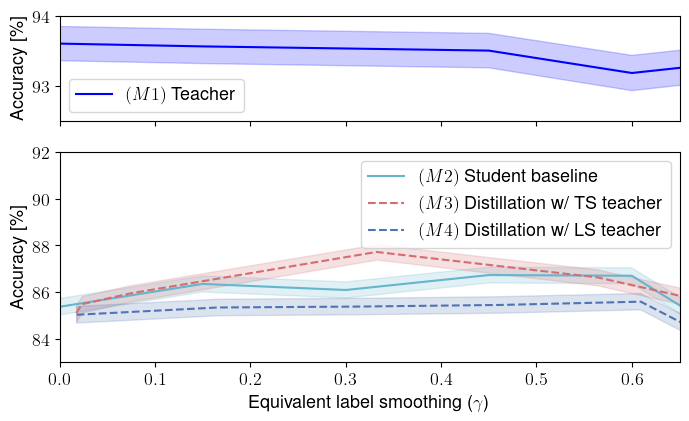

In [12]:
# Plot the accuracies
teacher = np.array(teacher)
student = np.array(student)
distillation_temperature = np.array(distillation_temperature)
distillation_smoothing = np.array(distillation_smoothing)

plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 13

fig, axs = plt.subplots(2,1,figsize=(8,4.5), gridspec_kw={'height_ratios': [1, 2]})

plt.setp(axs[0], xticklabels=[])

axs[0].plot(teacher[:,0], teacher[:,1], "-", label=r'$(M1)$ Teacher', color='#0000ff')
axs[0].fill_between(teacher[:,0], teacher[:,1]+teacher[:,2], teacher[:,1]-teacher[:,2], alpha=0.2, color='#0000ff')
axs[0].set_xlim([0,0.65])
axs[0].set_ylim([92.5, 94])
axs[0].set_ylabel("Accuracy [\%]")
axs[0].legend()

axs[1].plot(student[:,0], student[:,1], "-", label=r'$(M2)$ Student baseline', color='#64b5cd')
axs[1].fill_between(student[:,0], student[:,1]+student[:,2], student[:,1]-student[:,2], alpha=0.2, color='#64b5cd')
axs[1].plot(distillation_temperature[:,0], distillation_temperature[:,1], "--", label=r'$(M3)$ Distillation w/ TS teacher', color='#d46d6f')
axs[1].fill_between(distillation_temperature[:,0], distillation_temperature[:,1]+distillation_temperature[:,2], 
                    distillation_temperature[:,1]-distillation_temperature[:,2], alpha=0.2, color='#d46d6f')
plt.plot(distillation_smoothing[:,0], distillation_smoothing[:,1], "--", label=r'$(M4)$ Distillation w/ LS teacher', color='#4f74b2')
axs[1].fill_between(distillation_smoothing[:,0], distillation_smoothing[:,1]+distillation_smoothing[:,2], 
                    distillation_smoothing[:,1]-distillation_smoothing[:,2], alpha=0.2, color='#4f74b2')
axs[1].set_xlim([0,0.65])
axs[1].set_ylim([83, 92])
axs[1].set_ylabel("Accuracy [\%]")
axs[1].set_xlabel(r"Equivalent label smoothing ($\gamma$)")
axs[1].legend()
plt.show()

In [13]:
fig.savefig(format="pdf", fname="figures/resnet56_knowledge_distillation.pdf",bbox_inches='tight')